# Train IPC prediction NN using genetic algorithm

Investigate the effectiveness of the genetic algorithm for navigating the NN "Back Propagation" in the task of macroeconomic forecasting.

Five indicators of the Ukrainian economy are presented in the form of time series. The data is gathered during the period from 01/01/1995 to 12/01/1997. IPC is selected as predicted value.

In [1]:
import numpy as np
import pandas as pd

from lib.ml.layer.layer_def import Dense, Input
from lib.ml.util.loss_function import MEAN_SQUARED_ERROR
from lib.ml.model.seq_model import SeqNet
from lib.ml.optimizer.genetic_optimizer import GeneticOptimizer
from lib.ml.util.data_tweaks import rolling_window
from lib.ml.layer.layer_def import Reshape
from lib.ml.util.progress_tracker import NotebookProgressTracker
from src.data.economic.process_raw_economic_dataset import (
    ECONOMIC_DATASET_FILENAME,
    process_economic_raw_dataset,
)
from src.definitions import RAW_DATA_FOLDER
from src.visualization.plot import plot_diff, plot_loss

## Part 1: Train NN on all features

1. Load dataset.

In [2]:

dataset = pd.read_csv(RAW_DATA_FOLDER / ECONOMIC_DATASET_FILENAME, sep="\t")
dataset.head(4)

,M0,M2,IOC,IPC,KVVE
0,4.7,2.0,29.2,21.2,2.1
1,15.4,13.2,11.4,18.1,13.4
2,18.7,8.0,9.3,11.4,10.1
3,29.9,7.9,5.1,5.8,11.9


2. Prepare dataset.

In [3]:

processed_dataset = process_economic_raw_dataset(dataset)
display(processed_dataset)

,M0(-7),M2(-7),IOC(0),IPC(0),KVVE(-7),IPC(+1)
0,4.7,2.0,6.5,4.6,2.1,14.2
1,15.4,13.2,9.9,14.2,13.4,9.1
2,18.7,8.0,8.4,9.1,10.1,6.2
3,29.9,7.9,4.2,6.2,11.9,4.6
4,1.6,10.8,2.6,4.6,9.0,9.4
5,19.0,13.1,3.4,9.4,17.4,7.4
6,13.8,11.5,2.9,7.4,13.1,3.0
7,3.9,4.7,1.9,3.0,4.4,2.4
8,6.1,2.8,1.5,2.4,3.1,0.7
9,-5.1,-2.4,0.8,0.7,5.5,0.1


3. Define neural network with 5 inputs, 10 units in a hidden layer and 1 output. For optimization using genetic algorithm with population of 200 and 0.5 mutation ratio.

In [4]:
model = SeqNet(
    layers=[
        Input(shape=(12, 5)), 
        Reshape((-1,)), 
        Dense(10, use_bias=False), 
        Dense(1, use_bias=False)
    ]
)

opt = GeneticOptimizer(
    population_size=200, mutation_rate=0.5, mutation_decay=0.05
)

compiled_model = model.compile(
    optimizer=opt,
    loss=MEAN_SQUARED_ERROR,
    progress_tracker=NotebookProgressTracker(),
)

4. Train neural network for 1000 epochs.

In [5]:
x = rolling_window(processed_dataset.iloc[:, :-1].to_numpy(), 12).T
y = processed_dataset.iloc[12:, -1].to_numpy()

trained_model = compiled_model.fit(x, y, 1000)

print("Loss = " + str(trained_model.train_loss()))

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Loss = 2.0907617941630443e-09


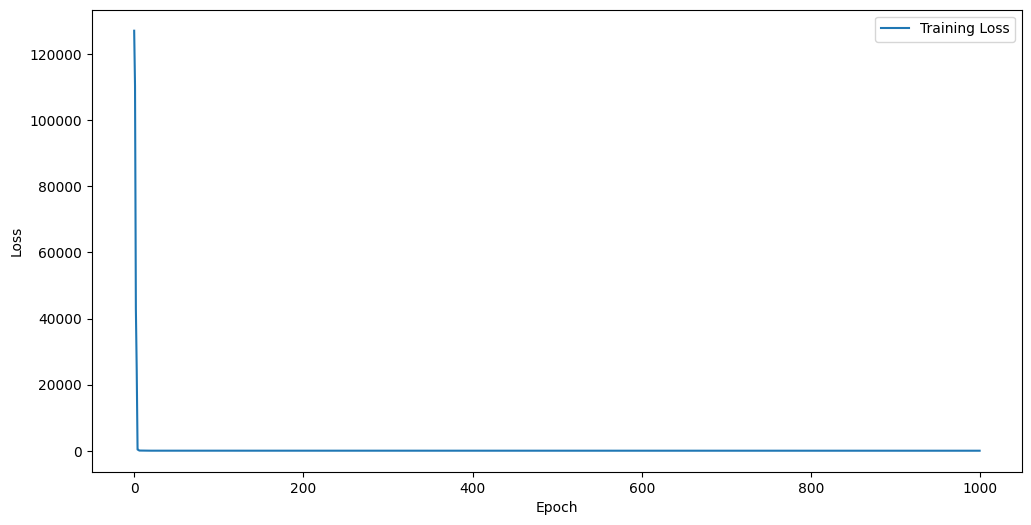

In [6]:
plot_loss(trained_model)

5. Check result and build report.

In [7]:
y_predicted = trained_model.predict(x).reshape((-1))
y_true = y.reshape((-1))
delta = y_true - y_predicted

report = pd.DataFrame(
    {
        "IPC RO": y_true,
        "IPC PO": y_predicted,
        "DELTA": delta,
        "DELTA^2": np.square(delta),
    }
)

display(report)

print("Delta total = " + str(report["DELTA"].sum()))
print("Delta^2 total = " + str(report["DELTA^2"].sum()))

,IPC RO,IPC PO,DELTA,DELTA^2
0,2.0,1.999959,0.000041,1.718977e-09
1,1.5,1.499985,0.000015,2.293570e-10
2,1.2,1.200018,-0.000018,3.377414e-10
3,0.9,0.900078,-0.000078,6.076972e-09


Delta total = -3.9727589877025515e-05
Delta^2 total = 8.363047176652177e-09


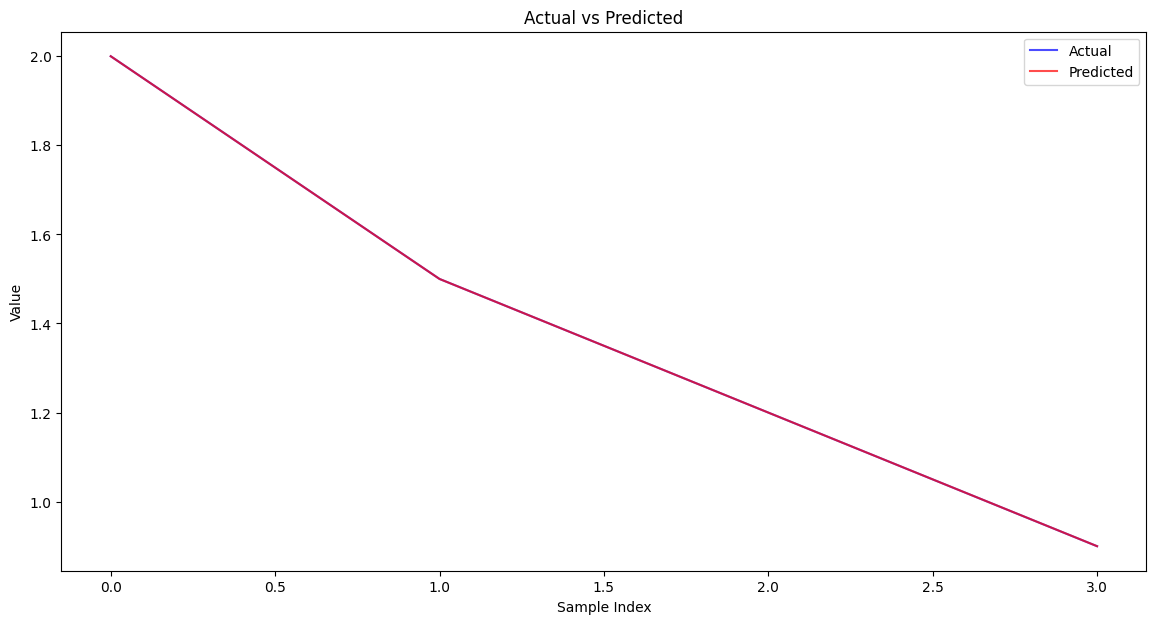

In [8]:
plot_diff(y_true, y_predicted)

## Part 2: Train NN on a subset of features (ІОС[0], IPC[0] and KVVE[-7])

1. Remove redundant columns from pre processed dataset.

In [9]:
reduced_dataset = processed_dataset.drop(columns=["M0(-7)", "M2(-7)"])

2. Create and train model.

In [10]:
reduces_model = SeqNet(
    layers=[
        Input(shape=(12, 3)),
        Reshape((-1,)),
        Dense(10, use_bias=False),
        Dense(1, use_bias=False),
    ]
)

compiled_reduces_model = reduces_model.compile(
    optimizer=opt,
    loss=MEAN_SQUARED_ERROR,
    progress_tracker=NotebookProgressTracker(),
)

x = rolling_window(reduced_dataset.iloc[:, :-1].to_numpy(), 12).T
y = reduced_dataset.iloc[12:, -1].to_numpy()

trained_reduces_model = compiled_reduces_model.fit(x, y, 1000)

print("Loss = " + str(trained_model.train_loss()))

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Loss = 2.0907617941630443e-09


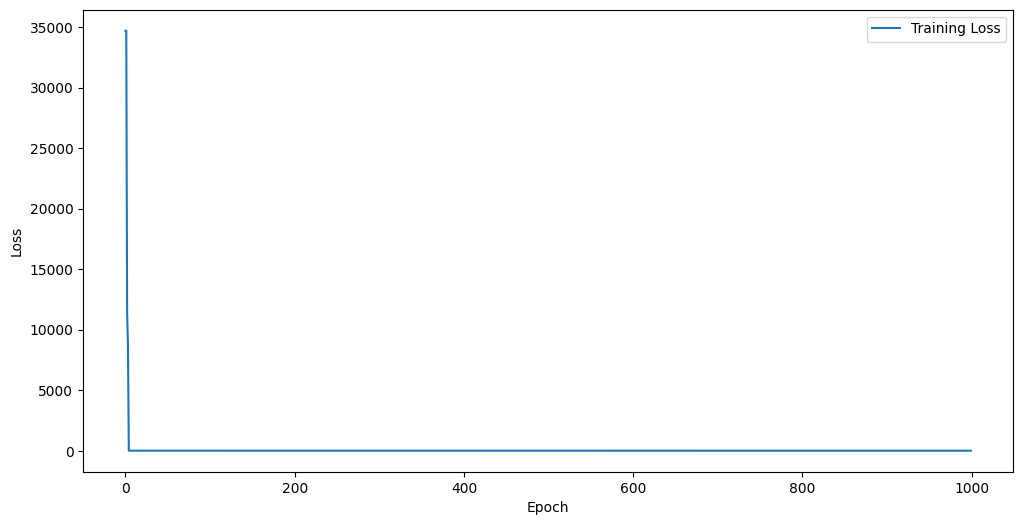

In [11]:
plot_loss(trained_reduces_model)

3. Check result and build report.

In [12]:
y_predicted = trained_reduces_model.predict(x).reshape((-1))
y_true = y.reshape((-1))
delta = y_true - y_predicted

report = pd.DataFrame(
    {
        "IPC RO": y_true,
        "IPC PO": y_predicted,
        "DELTA": delta,
        "DELTA^2": np.square(delta),
    }
)

display(report)

print("Delta total = " + str(report["DELTA"].sum()))
print("Delta^2 total = " + str(report["DELTA^2"].sum()))

,IPC RO,IPC PO,DELTA,DELTA^2
0,2.0,1.999494,0.000506,2.557328e-07
1,1.5,1.498472,0.001528,2.334024e-06
2,1.2,1.204594,-0.004594,2.110283e-05
3,0.9,0.889228,0.010772,1.160338e-04


Delta total = 0.008211566772139967
Delta^2 total = 0.0001397263573471469


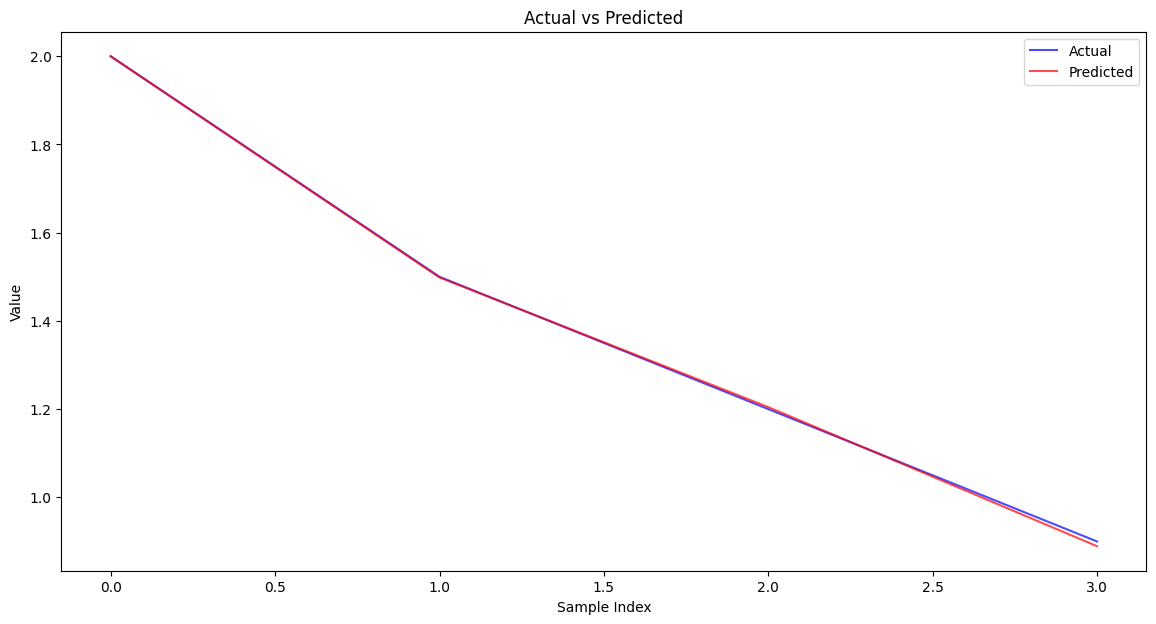

In [13]:
plot_diff(y_true, y_predicted)